In [1]:
%%capture capt
!pip install -r requirements.txt

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import pandas as pd
from tqdm import tqdm

import json
import yaml
import re

pd.set_option('future.no_silent_downcasting', True)

# Load data and tokens

In [3]:
with open('../data/entities.json', 'r') as f:
    data = json.load(f)

In [4]:
with open('../data/tokens.yml', 'r') as f:
    tokens = yaml.safe_load(f)
    
token_to_col = {}
for col in tokens.keys():
    token = tokens[col]['start']
    token_to_col[token] = col

# Preprocessing

In [5]:
def blank_dict(tokens=tokens):
    d = {}
    for col in list(tokens.keys()):
        d[col] = None
    return d

def split_by_token(line, token_to_col=token_to_col):
    tokens_to_split = list(token_to_col.keys())
    pattern = '(' + '|'.join(re.escape(token) for token in tokens_to_split) + ')'
    
    splits = re.split(pattern, line)
    # Filter out empty strings and trim kept strings
    splits = [part.strip() for part in splits if part]
    return splits

def split_to_dict(split, token_to_col=token_to_col, dict_split=None):
    if dict_split is None:
        dict_split = blank_dict()
    for i in range(0, len(split), 2):
        token = split[i]
        element = split[i+1]
        column = token_to_col[token]
        dict_split[column] = element
    return dict_split

In [6]:
df_dict = {}
counter = 0
for key in tqdm(data.keys()): 
    for line in data[key].split('\n'):
        try:
            split = split_by_token(line)
            split_dict = split_to_dict(split)
            df_dict[counter] = split_dict
                    
            counter += 1
        except:
            pass

100%|██████████| 1218/1218 [00:00<00:00, 3285.06it/s]


In [7]:
df = pd.DataFrame().from_dict(df_dict, orient='index').fillna(value=np.nan)

indices_to_remove = []
for i in range(len(df)):
    if np.all(df.iloc[i].isna()):
        indices_to_remove.append(i)

df = df.loc[~df.index.isin(indices_to_remove)]

In [8]:
X = df.drop(columns=['surname_household'])
y = df['surname_household'].apply(
                                lambda x: 0 if pd.isna(x) else 1
                            )

# Data Statistics

In [9]:
X.describe()

,age,birth_date,civil_status,education_level,employer,firstname,link,lob,maiden_name,nationality,observation,occupation,surname
count,16435,7344,10704,0,2911,24930,20735,9235,0,13314,602,16178,19159
unique,253,158,6,0,1087,2456,937,2923,0,73,310,2056,8120
top,2,1901,Garçon,NaN,patron,Marie,chef,idem,NaN,française,idem,idem,idem
freq,337,138,2824,NaN,644,2758,3022,3377,NaN,7916,88,3695,669


In [10]:
print(f"There are {100*y.mean():.2f}% of people within the database that have a household surname.")

There are 22.49% of people within the database that have a household surname.


In [11]:
print(f"There is a total of {len(X)} people registered in the database.")

There is a total of 25074 people registered in the database.


In [12]:
n = 0
for i in range(len(df)):
    if np.all(pd.isna(df.iloc[i])):
        n += 1
print(f"There are {n} rows in the database that have no information whatsoever")

There are 0 rows in the database that have no information whatsoever


# Profiling

### Mean age

In [13]:
mean_age = 0
age_count = 0

for i in range(len(df)):
    try:
        age = float(df.iloc[i].age)
        if not pd.isna(age):
            mean_age += age
            age_count += 1
    except:
        pass

In [14]:
mean_age /= age_count
print(f"For people whose age is available, the average age is {mean_age:.4f}")

For people whose age is available, the average age is 33.9280


### Civil status

In [15]:
from matplotlib.ticker import PercentFormatter

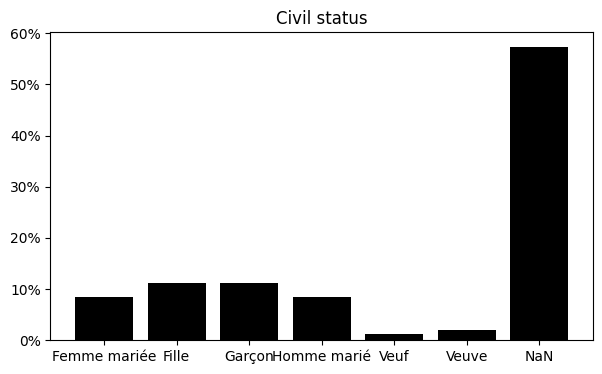

In [30]:
plt.figure(figsize=(7,4))
labels, counts = np.unique(df.civil_status.dropna(), return_counts=True)

labels = list(labels) + ['NaN']
counts = np.array(list(counts) + [len(df) - len(df.civil_status.dropna())])

counts = counts / len(df)
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Civil status')
plt.show()

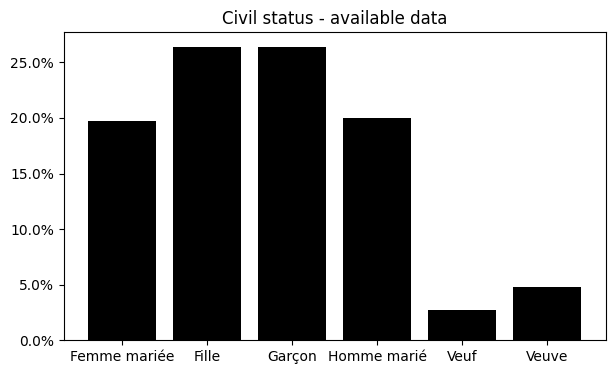

In [32]:
plt.figure(figsize=(7,4))
labels, counts = np.unique(df.civil_status.dropna(), return_counts=True)
counts = counts / len(df.civil_status.dropna())
plt.bar(labels, counts, align='center', color = 'black')
plt.gca().set_xticks(labels)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Civil status - available data')
plt.show()